In [101]:
import numpy as np
import os

In [102]:
os.environ["CUDA_VISIBLE_DEVICES"]="6"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [103]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [104]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [105]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

In [106]:
import time

# Load Model

In [107]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
model_ = ResNet50(input_shape=input_shape)

In [108]:
q_model = tfmot.quantization.keras.quantize_model(model_)
model = ResNet50(input_tensor = q_model.input)

In [109]:
model.load_weights("./original_model_40.h5")
q_model.load_weights("./int8_model_40.h5")

# Load images

In [110]:
labels = np.load('/local/rcs/wei/image_net/one_im_per_class_lables.npy')
images = np.load('/local/rcs/wei/image_net/one_im_per_class.npy')
ad_labels = np.load('/local/rcs/wei/image_net/one_image_per_class/int8/labels.npy')

In [111]:
ad_images = {}
directory = '/local/rcs/wei/image_net/one_image_per_class/int8/'
for filename in os.listdir(directory):
    if filename.endswith(".npy") and not filename.endswith("labels.npy"):
        index = int(re.findall(r'\d+',filename)[0])
        ad_images[index] = np.load(os.path.join(directory, filename))

In [114]:
attacks = 0
for label in ad_images:
    ad_im = ad_images[label]
    orig_im = images[np.where(labels == label)[0][0]]
    attack = ad_im -  deprocess_image(orig_im)
    attacks += attack

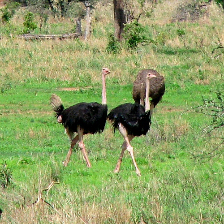

In [88]:
from IPython.display import Image
display(tf.keras.preprocessing.image.array_to_img(ad_im))

In [89]:
ad_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(ad_im),axis = 0)

In [90]:
logits_1,logits_2 = model(ad_image),q_model(ad_image)

In [91]:
tf.keras.applications.resnet.decode_predictions(logits_1.numpy(), top=5)[0]

[('n01518878', 'ostrich', 0.9592879),
 ('n02410509', 'bison', 0.031611566),
 ('n02408429', 'water_buffalo', 0.0067395982),
 ('n02018795', 'bustard', 0.0005898685),
 ('n02422106', 'hartebeest', 0.00039172938)]

In [92]:
tf.keras.applications.resnet.decode_predictions(logits_2.numpy(), top=5)[0]

[('n02408429', 'water_buffalo', 0.3018614),
 ('n02410509', 'bison', 0.3018614),
 ('n01518878', 'ostrich', 0.26248866),
 ('n02403003', 'ox', 0.056421194),
 ('n02437312', 'Arabian_camel', 0.009170219)]

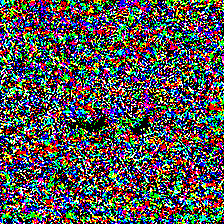

In [100]:
from IPython.display import Image
display(tf.keras.preprocessing.image.array_to_img(attack))

In [115]:
attacks = attacks/1000

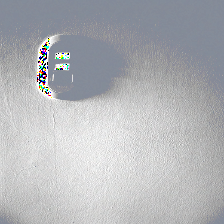

In [116]:
from IPython.display import Image
display(tf.keras.preprocessing.image.array_to_img(attack))